In [122]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Load specific forecasting tools
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset/demand_dataframe.csv')[['Time' ,'COA']]
df.head()

,Time,COA
0,01-01-12 1:00,5986.0
1,01-01-12 2:00,5547.0
2,01-01-12 3:00,5233.0
3,01-01-12 4:00,5150.0
4,01-01-12 5:00,5235.0


In [3]:
df[df.Time=='01-08-15 0:00']

,Time,COA
31391,01-08-15 0:00,15277.0


In [4]:
df_temp = pd.read_csv('dataset/df_weather2012-2018.csv')[['time' , 'temperature']]

In [5]:
df_temp['Time']=df_temp.time.map(lambda x: time.strftime("%d-%m-%Y %H:%M:%S", time.localtime(x)))

In [6]:
df_test = pd.DataFrame(pd.date_range('2012-01-01 01:00:00' , '2017-12-31 23:00:00' , freq='1H') , columns=['Time'])

In [7]:
df_test.index.freq = 'H'

In [8]:
df_test.index

RangeIndex(start=0, stop=52607, step=1)

In [9]:
df_test.head()

,Time
0,2012-01-01 01:00:00
1,2012-01-01 02:00:00
2,2012-01-01 03:00:00
3,2012-01-01 04:00:00
4,2012-01-01 05:00:00


In [10]:
df_temp.head()

,time,temperature,Time
0,1325365200,14.98,01-01-2012 00:00:00
1,1325368800,13.98,01-01-2012 01:00:00
2,1325372400,11.98,01-01-2012 02:00:00
3,1325376000,11.98,01-01-2012 03:00:00
4,1325379600,11.98,01-01-2012 04:00:00


In [11]:
df_temp.drop(columns=['time'] , inplace=True)

In [12]:
df = df.set_index('Time')
df_temp = df_temp.set_index('Time')
df_test = df_test.set_index('Time')

In [13]:
df.index = pd.to_datetime(df.index, format="%d-%m-%y %H:%M" , dayfirst=True)
df_temp.index = pd.to_datetime(df_temp.index)
df_test.index = pd.to_datetime(df_test.index)

In [14]:
df.tail()

,COA
Time,
2017-12-31 19:00:00,9495.0
2017-12-31 20:00:00,9365.0
2017-12-31 21:00:00,9250.0
2017-12-31 22:00:00,8931.0
2017-12-31 23:00:00,8679.0


In [15]:
df_temp.head()

,temperature
Time,
2012-01-01 00:00:00,14.98
2012-01-01 01:00:00,13.98
2012-01-01 02:00:00,11.98
2012-01-01 03:00:00,11.98
2012-01-01 04:00:00,11.98


In [16]:
df_temp.tail()

,temperature
Time,
2018-12-31 19:00:00,16.65
2018-12-31 20:00:00,14.73
2018-12-31 21:00:00,14.76
2018-12-31 22:00:00,13.81
2018-12-31 23:00:00,12.83


In [17]:
df_t = df_temp['2012-01-01 01:00:00':'2017-12-31 23:00:00'].merge(df_test , how = 'outer' ,on = 'Time' ).sort_values('Time')

In [18]:
df_l = df['2012-01-01 01:00:00':'2017-12-31 23:00:00'].merge(df_test , how = 'outer' ,on = 'Time' ).sort_values('Time')

In [19]:
len(df_l)

52607

In [20]:
len(df_t)

52607

In [21]:
df_t.fillna(method='ffill' , inplace=True)

In [22]:
df_t.isnull().sum()

temperature    0
dtype: int64

In [23]:
df_l.index.freq = '1H'

In [24]:
df_t.index.freq = '1H'

In [25]:
df_l['temp'] = df_t.temperature.values

In [26]:
df_l = df_l.reset_index()

In [27]:
df_l.dtypes

Time    datetime64[ns]
COA            float64
temp           float64
dtype: object

In [28]:
df_l['year'] = df_l['Time'].apply(lambda x: x.year)
df_l['quarter'] = df_l['Time'].apply(lambda x: x.quarter)
df_l['month'] = df_l['Time'].apply(lambda x: x.month)
df_l['day'] = df_l['Time'].apply(lambda x: x.day)
# df_l=df_l.loc[:,['Time','COA', 'year','quarter','month','day']]
df_l.sort_values('Time', inplace=True, ascending=True)
# df = df.reset_index(drop=True)
df_l["weekday"]=df_l.apply(lambda row: row["Time"].weekday(),axis=1)
df_l["weekday"] = df_l["weekday"].astype(str)
df_l = pd.get_dummies(df_l)

In [29]:
df_l.head()

,Time,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2012-01-01 01:00:00,5986.0,13.98,2012,1,1,1,0,0,0,0,0,0,1
1,2012-01-01 02:00:00,5547.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2,2012-01-01 03:00:00,5233.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
3,2012-01-01 04:00:00,5150.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
4,2012-01-01 05:00:00,5235.0,11.98,2012,1,1,1,0,0,0,0,0,0,1


In [30]:
# df_l.to_csv('full_COA.csv' , index=False)

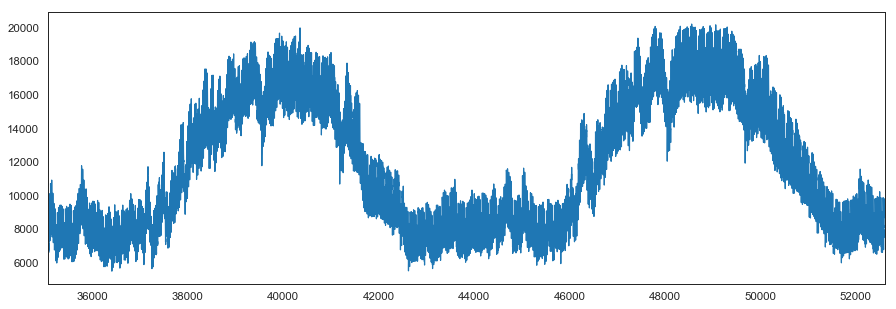

In [31]:
df_l[df_l.Time > '2016-01-01 01:00:00'].COA.plot(figsize=(15,5)).autoscale(axis='x',tight=True)

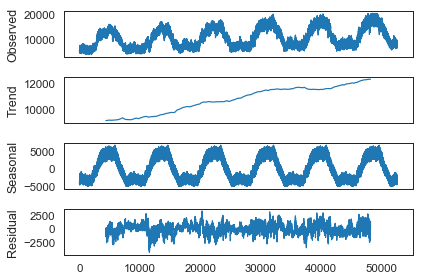

In [32]:
seasonal_decompose(df_l.COA, freq=365*24).plot();

In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [34]:
adf_test(df_l.COA)

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.208369
p-value                     0.019505
# lags used                58.000000
# observations          52548.000000
critical value (1%)        -3.430474
critical value (5%)        -2.861595
critical value (10%)       -2.566799
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [35]:
l_df = len(df_l[df_l.Time >= '2012-01-01 01:00:00'])

In [36]:
l_split = len(df_l[df_l.Time >= '2017-01-01 00:00:00'])

In [37]:
train = df_l.iloc[:(l_df-l_split)]
test = df_l.iloc[(l_df-l_split):]

In [38]:
l_split

8760

In [146]:
dataset = df_l.COA.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
train_size = l_df-l_split
test_size = len(dataset) - train_size
train, test = scaler.fit_transform(dataset[0:train_size,:]), scaler.transform(dataset[train_size:len(dataset),:])

In [147]:
l_df-l_split

43847

In [148]:
train_size

43847

In [149]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [150]:
len(train)

43847

In [151]:
len(test)

8760

In [152]:
# reshape into X=t and Y=t+1
look_back = 24
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [153]:
X_train.shape

(43822, 24)

In [154]:
Y_train.shape

(43822,)

In [155]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [156]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
opt = optimizers.Adam(lr=.001)
model.compile(loss='mean_squared_error', optimizer=opt)

history = model.fit(X_train, Y_train, epochs=30, batch_size=24, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 43822 samples, validate on 8735 samples
Epoch 1/30
43822/43822 [==============================] - 6s 141us/step - loss: 0.0037 - val_loss: 0.0802
Epoch 2/30
43822/43822 [==============================] - 6s 131us/step - loss: 0.0029 - val_loss: 0.0786
Epoch 3/30
43822/43822 [==============================] - 6s 130us/step - loss: 0.0030 - val_loss: 0.0723
Epoch 4/30
43822/43822 [==============================] - 6s 129us/step - loss: 0.0033 - val_loss: 0.0549
Epoch 5/30
43822/43822 [==============================] - 6s 130us/step - loss: 0.0032 - val_loss: 0.0365
Epoch 6/30
43822/43822 [==============================] - 6s 129us/step - loss: 0.0029 - val_loss: 0.0222
Epoch 7/30
43822/43822 [==============================] - 6s 130us/step - loss: 0.0025 - val_loss: 0.0143
Epoch 8/30
43822/43822 [==============================] - 6s 128us/step - loss: 0.0022 - val_loss: 0.0095
Epoch 9/30
43822/43822 [==============================] - 6s 133us/step - loss: 0.0020 - val_loss: 0.00

In [157]:
# len(model.predict(X_test, steps=2))

In [158]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
# print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
# print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
# print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 802.1224559489293
Train Root Mean Squared Error: 1059.0901789459901
Test Mean Absolute Error: 1120.861811721614
Test Root Mean Squared Error: 1471.7294490535162


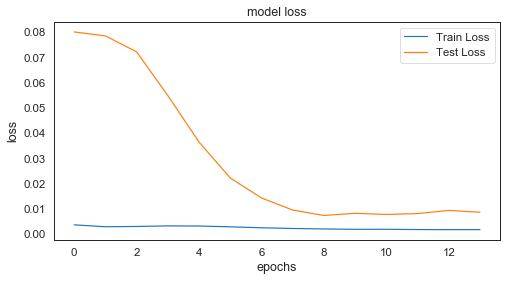

In [159]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

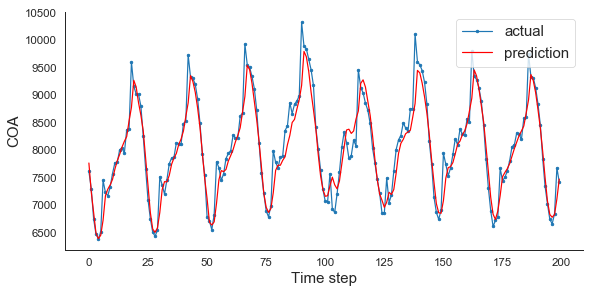

In [160]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('COA', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [82]:
df_l = df_l.set_index('Time')

KeyError: 'Time'

In [135]:
Y_test.shape

(1, 8735)

In [136]:
test_predict.shape

(8735, 1)

In [137]:
Y_train.shape

(1, 43822)

In [138]:
-(look_back*2+2)

-50

In [139]:
tes = pd.DataFrame(Y_test.reshape(Y_test.shape[1],Y_test.shape[0]) , columns=['test'] , index= df_l.iloc[train_size+look_back:-1].index)

In [140]:
pre = pd.DataFrame(test_predict , columns=['pred'] , index= df_l.iloc[train_size+look_back:-1].index)

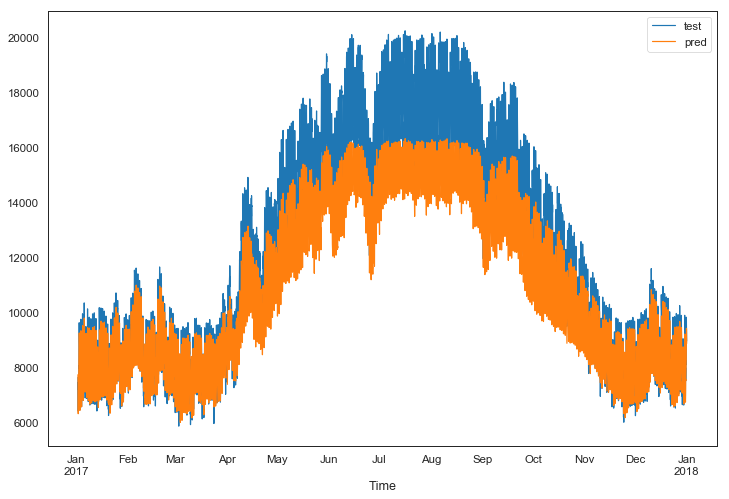

In [144]:
# df_l.COA['2017-01-01 00:00:00':].plot(figsize=(12,8) , legend=True)
# y_t.train['2012-01-01 00:00:00':'2012-02-01 00:00:00'].plot(legend=True)
tes.test['2017-01-01 00:00:00':].plot(legend=True, figsize=(12,8))
pre.pred['2017-01-01 00:00:00':].plot(legend=True)

In [91]:
rmse(tes.test , pre.pred)

1348.4931812295642

In [92]:
tes.test.mean()

12337.889055496344

In [93]:
pre.pred.mean()

11398.534